# Neural Style Transfer

## 컨볼루션 신경망을 사용한 텍스처 합성

* Texture(질감) : 지역적으로는 비교적 다양한 값을 가지면서 전체적으로는 비슷한 모습을 보이는 이미지
* Texture Synthesis(텍스처 합성) : 한 장의 이미지를 원본으로 삼아 특정 텍스처를 재생성(합성) 하는 작업, 합성된 이미지는 원본과 비슷하지만 똑같아서는 안되며, 어색하나거 반복적인 부분이 있으면 안됨
딥러닝 알고리즘을 사용하여 이미지의 공간적 통계값(Spacial Statistics) 학습

In [1]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Package

In [2]:
import tensorflow as tf 

# I. Texture

> ## 1) 원본 텍스처

106496/100154 [===============================] - 0s 0us/step


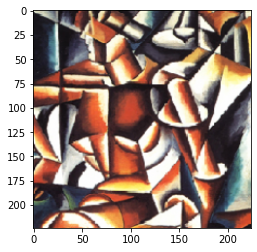

In [3]:
import matplotlib.pyplot as plt
import cv2

# style_path = tf.keras.utils.get_file('style.jpg', 'http://bit.ly/2mGfZIq')
style_path = tf.keras.utils.get_file('style.jpg', 'https://raw.githubusercontent.com/rusita-ai/pyData/master/popova.jpg')

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224, 224))
style_image = style_image / 255.0
plt.imshow(style_image)
plt.show()

> ## 2) 타겟 텍스처

* 원본 텍스처 크기로 생성

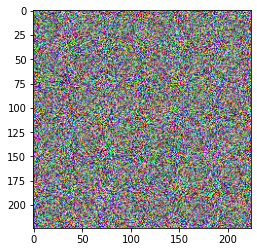

In [4]:
target_image = tf.random.uniform(style_image.shape)

plt.imshow(target_image)
plt.show()

# II. VGG19

> ## 1) VGG-19 CNN Layer

In [5]:
from tensorflow.keras.applications import VGG19

vgg = VGG19(weights = 'imagenet',
            include_top = False)

80142336/80134624 [==============================] - 1s 0us/step


* Model Summary

In [6]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

> ## 2) 특징 추출 레이어

In [7]:
vgg.trainable = False

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

outputs = [vgg.get_layer(name).output for name in style_layers]

model = tf.keras.Model([vgg.input], outputs)

* Model Summary

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# III. Gram Matrix

Gram Matrix : 1차원으로 변경된 특징추출 벡터를 쌓아올린 행렬을 자신의 전치(Transpose)행렬과 행렬곱(@)하여 얻은 값
 - 특징 추출값의 상관관계를 나타냄

* 원본 텍스처와 타깃 텍스청 대한 모두 계산 후 
 - 두 Gram Matrix의 MSE가 작아지도록 학습 


> ## 1) 'gram_matrix( )' 함수 정의

In [9]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

> ## 2) 원본 텍스처 Gram Matrix

In [10]:
from tensorflow.keras.applications.vgg19 import preprocess_input

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis = 0)
style_output = model(preprocess_input(style_batch * 255.0))

In [11]:
style_outputs = [gram_matrix(out) for out in style_output]

* 원본 텍스처 첫번째 특징 추출값

(1, 224, 224, 64)


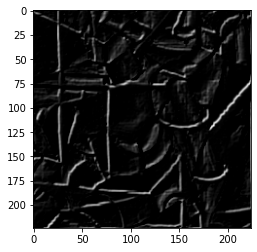

In [12]:
print(style_output[0].shape)
plt.imshow(tf.squeeze(style_output[0][:,:,:,0], 0), cmap = 'gray')
plt.show()

> ## 3) 타겟 텍스처 업데이트 함수

* get_outputs( )
* get_loss( )
* clip_0_1( )

In [13]:
def get_outputs(image):
    image_batch = tf.expand_dims(image, axis = 0)
    output = model(preprocess_input(image_batch * 255.0))
    outputs = [gram_matrix(out) for out in output]
    return outputs
  
def get_loss(outputs, style_outputs):
    return tf.reduce_sum([tf.reduce_mean((o - s) ** 2) for o,s in zip(outputs, style_outputs)])
  
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

> ## 4) 'tf.GradientTape( )' 이미지 업데이트

In [14]:
opt = tf.optimizers.Adam(learning_rate = 0.2, 
                         beta_1 = 0.99, 
                         epsilon = 0.1)

def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = get_loss(outputs, style_outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# IV. 텍스처 합성

* 약 4분

In [15]:
%%time

import IPython.display as display
import time
import imageio

image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step = step + 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_epoch_{0}.png'.format(n), image.read_value().numpy())
    # display.clear_output(wait = True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# V. Validation Loss

### 픽셀의 바로 옆 인접 픽셀과의 차이
* 차이가 작을 수록 이미지가 매끄럽게 보임

> ## 1) Varitation Loss 함수 정의

* high_pass_x_y( )
* total_validation_loss( )

In [16]:
def high_pass_x_y(image):
    x_var = image[:, 1:, :] - image[:, :-1, :]
    y_var = image[1:, :, :] - image[:-1, :, :]
    return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas ** 2) + tf.reduce_mean(y_deltas ** 2)

> ## 2) Variation Loss 비교

In [17]:
print('target   :', total_variation_loss(image.read_value()))
print('noise    :', total_variation_loss(tf.random.uniform(style_image.shape)))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.07248313, shape=(), dtype=float32)
noise    : tf.Tensor(0.3323761, shape=(), dtype=float32)
original : tf.Tensor(0.021080896997270143, shape=(), dtype=float64)


> ## 3) Variation Loss 계산식에 추가

In [18]:
total_variation_weight = 1000000000
style_weight = 0.1

def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

> ## 4) 텍스처 합성 재실행

* 약 4분

In [19]:
%%time

target_image = tf.random.uniform(style_image.shape)
image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step = step + 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_variation_epoch_{0}.png'.format(n), image.read_value().numpy())
    # display.clear_output(wait = True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

> ## 5) 원본과 타겟 Variation Loss 비교

In [20]:
print('target   :', total_variation_loss(image.read_value()))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.023675758, shape=(), dtype=float32)
original : tf.Tensor(0.021080896997270143, shape=(), dtype=float64)


# VI. Neural Style Transfer

> ## 1) content 텍스처

65536/57696 [==================================] - 0s 0us/step


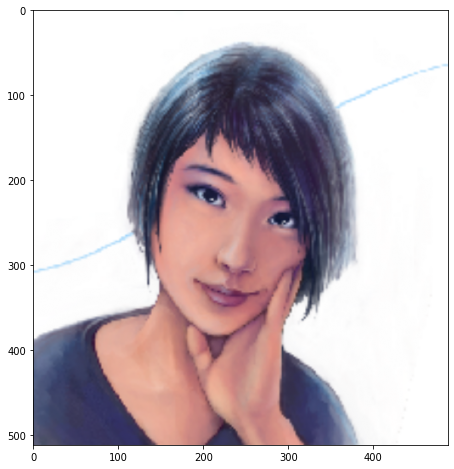

In [21]:
import matplotlib.pyplot as plt
import cv2

# content_path = tf.keras.utils.get_file('content.jpg', 'http://bit.ly/2mAfUX1')
content_path = tf.keras.utils.get_file('content.jpg', 'https://raw.githubusercontent.com/rusita-ai/pyData/master/portrait.png')

content_image = plt.imread(content_path)
max_dim = 512
long_dim = max(content_image.shape[:-1])
scale = max_dim / long_dim
new_height = int(content_image.shape[0] * scale)
new_width = int(content_image.shape[1] * scale)

content_image = cv2.resize(content_image, dsize = (new_width, new_height))
content_image = content_image / 255.0
plt.figure(figsize = (8, 8))
plt.imshow(content_image)
plt.show()

> ## 2) content 특징 추출 모델

In [22]:
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis = 0)

content_layers = ['block5_conv2']

vgg.trainable = False

outputs = [vgg.get_layer(name).output for name in content_layers]

model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch * 255.0))

> ## 3) 함수 정의

* get_content_output( )
* get_content_loss( )

In [23]:
def get_content_output(image):
    image_batch = tf.expand_dims(image, axis = 0)
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image - content_output) ** 2)

> ## 4) 'Content Loss' 계산식에 추가

In [24]:
opt = tf.optimizers.Adam(learning_rate = 0.001, 
                         beta_1 = 0.99, 
                         epsilon = 0.1)

total_variation_weight = 1e9
style_weight = 0.01
content_weight = 10000

def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += content_weight * get_content_loss(output2, content_output)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

> ## 5) 텍스처 합성

* 약 20분

In [25]:
%%time

# 8.62 Neural Style Transfer 실행

# target_image = tf.random.uniform(content_image.shape)
image = tf.Variable(content_image.astype('float32'))

epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step = step + 1
        train_step(image)
        print(".", end = '')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'.format(style_weight, content_weight, n), image.read_value().numpy())
    # display.clear_output(wait = True)
    plt.figure(figsize = (8, 8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

> ## 6) 레이어별 특징 출력

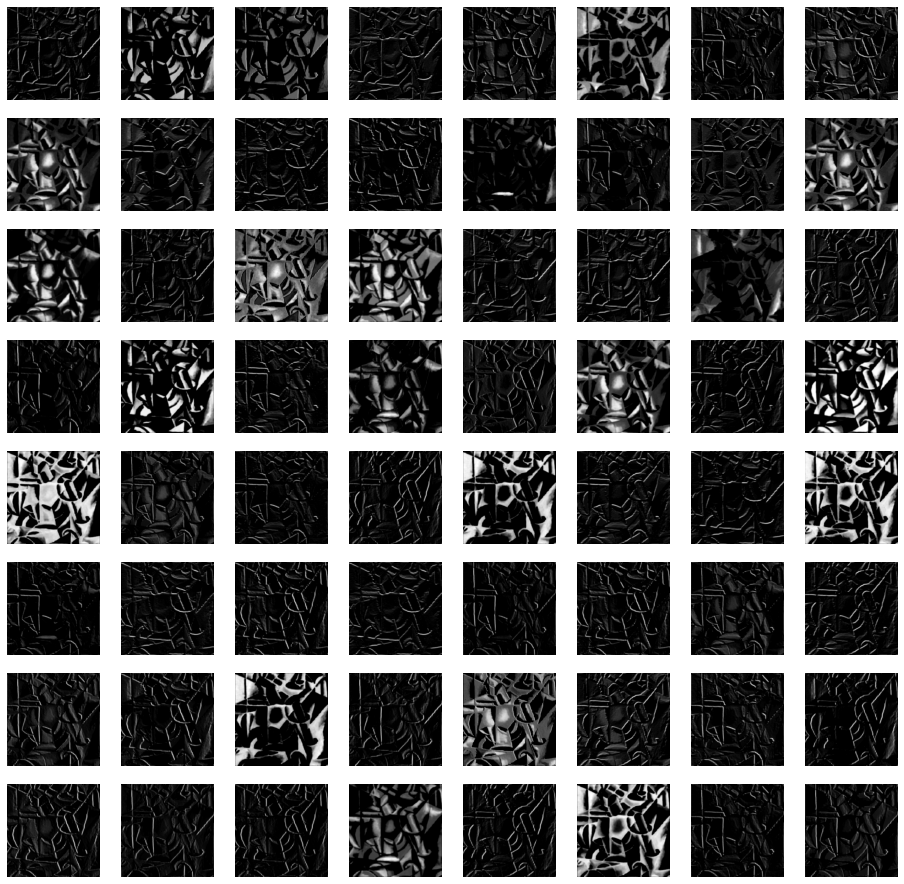

In [26]:
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float')
style_batch = tf.expand_dims(style_batch, axis = 0)
style_output = model(preprocess_input(style_batch * 255.0))

plt.figure(figsize = (16, 16))

for i in range(style_output[0].shape[-1]):
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.imshow(tf.squeeze(style_output[0][:, :, :, i], 0), cmap = 'gray')

# 
# 
# 
# The End
# 
# 
# 